# 05. Transfer Learning with TensorFlow Part 2: Fine-tuning

In the previous section, we saw how we could leverage feature extraction transfer learning to get far better results on our Food Vision project than building our own models (even with less data).

Now we're going to cover another type of transfer learning: fine-tuning.

In **fine-tuning transfer learning** the pre-trained model weights from another model are unfrozen and tweaked during to better suit your own data.

For feature extraction transfer learning, you may only train the top 1-3 layers of a pre-trained model with your own data, in fine-tuning transfer learning, you might train 1-3+ layers of a pre-trained model (where the '+' indicates that many or all of the layers could be trained).

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/05-transfer-learning-feature-extraction-vs-fine-tuning.png)
*Feature extraction transfer learning vs. fine-tuning transfer learning. The main difference between the two is that in fine-tuning, more layers of the pre-trained model get unfrozen and tuned on custom data. This fine-tuning usually takes more data than feature extraction to be effective.*



## What we're going to cover

We're going to go through the follow with TensorFlow:

- Introduce fine-tuning, a type of transfer learning to modify a pre-trained model to be more suited to your data
- Using the Keras Functional API (a differnt way to build models in Keras)
- Using a smaller dataset to experiment faster (e.g. 1-10% of training samples of 10 classes of food)
- Data augmentation (how to make your training dataset more diverse without adding more data)
- Running a series of modelling experiments on our Food Vision data
  - **Model 0**: a transfer learning model using the Keras Functional API
  - **Model 1**: a feature extraction transfer learning model on 1% of the data with data augmentation
  - **Model 2**: a feature extraction transfer learning model on 10% of the data with data augmentation
  - **Model 3**: a fine-tuned transfer learning model on 10% of the data
  - **Model 4**: a fine-tuned transfer learning model on 100% of the data
- Introduce the ModelCheckpoint callback to save intermediate training results
- Compare model experiments results using TensorBoard


In [53]:
import tensorflow as tf

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.17.0


In [54]:
# Are we using a GPU?
!nvidia-smi

Sat Jan 25 07:50:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.02              Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 ...    On  |   00000000:65:00.0 Off |                  N/A |
| N/A   45C    P8              4W /   77W |    5677MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Creating helper functions

Throughout your machine learning experiments, you'll likely come across snippets of code you want to use over and over again.

For example, a plotting function which plots a model's `history` object (see `plot_loss_curves()` below).

You could recreate these functions over and over again.

But as you might've guessed, rewritting the same functions becomes tedious.

One of the solutions is to store them in a helper script such as [`helper_functions.py`](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py). And then import the necesary functionality when you need it.

For example, you might write:

```
from helper_functions import plot_loss_curves

...

plot_loss_curves(history)
```

Let's see what this looks like.

In [55]:
# Get helper_functions.py script from course GitHub
# !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import helper functions we're going to use
from helper_functions import plot_loss_curves, unzip_data, walk_through_dir

In [56]:
import tensorflow as tf

log_dir = "logs/transfer_learning_part_2"

def create_tensorboard_callback(experiment_name, dir_name=log_dir):
    log_dir = dir_name + "/" + experiment_name
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

## 10 Food Classes: Working with less data

We saw in the [previous notebook](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb) that we could get great results with only 10% of the training data using transfer learning with TensorFlow Hub.

In this notebook, we're going to continue to work with smaller subsets of the data, except this time we'll have a look at how we can use the in-built pretrained models within the [`tf.keras.applications`](https://www.tensorflow.org/api_docs/python/tf/keras/applications) module as well as how to fine-tune them to our own custom dataset.

We'll also practice using a new but similar dataloader function to what we've used before, [`image_dataset_from_directory()`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) which is part of the [`tf.keras.utils`](https://www.tensorflow.org/api_docs/python/tf/keras/utils) module.

Finally, we'll also be practicing using the [Keras Functional API](https://keras.io/guides/functional_api/) for building deep learning models. The Functional API is a more flexible way to create models than the tf.keras.Sequential API.

We'll explore each of these in more detail as we go.

Let's start by downloading some data.

In [57]:
# Get 10% of the data of the 10 classes
# Download data (Skip, load the data locally)

# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# unzip_data("10_food_classes_10_percent.zip")

In [58]:
food_classes_dir = "data/image_data/10_food_classes_10_percent"

# Walk through 10 percent data directory and list number of files
walk_through_dir(food_classes_dir)

There are 2 directories and 0 images in 'data/image_data/10_food_classes_10_percent'.
There are 10 directories and 0 images in 'data/image_data/10_food_classes_10_percent/test'.
There are 0 directories and 250 images in 'data/image_data/10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in 'data/image_data/10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in 'data/image_data/10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in 'data/image_data/10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in 'data/image_data/10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in 'data/image_data/10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in 'data/image_data/10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in 'data/image_data/10_food_classes_10_percent/test/

We can see that each of the training directories contain 75 images and each of the testing directories contain 250 images.

Let's define our training and test filepaths.

In [59]:
train_dir = food_classes_dir + "/train/"
test_dir = food_classes_dir + "/test/"

Now we've got some image data, we need a way of loading it into a TensorFlow compatible format.

Previously, we've used the [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) class.

However, as of August 2023, this class is deprecated and isn't recommended for future usage (it's too slow).

Because of this, we'll move onto using `tf.keras.utils.image_dataset_from_directory()`.

This method expects image data in the following file format:

```
Example of file structure

10_food_classes_10_percent <- top level folder
└───train <- training images
│   └───pizza
│   │   │   1008104.jpg
│   │   │   1638227.jpg
│   │   │   ...      
│   └───steak
│       │   1000205.jpg
│       │   1647351.jpg
│       │   ...
│   
└───test <- testing images
│   └───pizza
│   │   │   1001116.jpg
│   │   │   1507019.jpg
│   │   │   ...      
│   └───steak
│       │   100274.jpg
│       │   1653815.jpg
│       │   ...    
```

One of the main benefits of using [`tf.keras.prepreprocessing.image_dataset_from_directory()`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) rather than `ImageDataGenerator` is that it creates a [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) object rather than a generator.

The main advantage of this is the `tf.data.Dataset` API is much more efficient (faster) than the `ImageDataGenerator` API which is paramount for larger datasets.

Let's see it in action.

In [60]:
# Create data inputs
import tensorflow as tf

IMG_SIZE = (224, 224)  # define image size

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_dir,
    image_size=IMG_SIZE,
    label_mode="categorical",  # what type are the labels?
    batch_size=32)  # batch_size is 32 by default, this is generally a good number

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Wonderful! Looks like our dataloaders have found the correct number of images for each dataset.

For now, the main parameters we're concerned about in the `image_dataset_from_directory()` funtion are:
* `directory` - the filepath of the target directory we're loading images in from.
* `image_size` - the target size of the images we're going to load in (height, width).
* `batch_size` - the batch size of the images we're going to load in. For example if the `batch_size` is 32 (the default), batches of 32 images and labels at a time will be passed to the model.

There are more we could play around with if we needed to [in the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory).

If we check the training data datatype we should see it as a `BatchDataset` with shapes relating to our data.

In [61]:
# Check the training data datatype
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In the above output:

* `(None, 224, 224, 3)` refers to the tensor shape of our images where `None` is the batch size, `224` is the height (and width) and `3` is the color channels (red, green, blue).
* `(None, 10)` refers to the tensor shape of the labels where `None` is the batch size and `10` is the number of possible labels (the 10 different food classes).
* Both image tensors and labels are of the datatype `tf.float32`.

The `batch_size` is `None` due to it only being used during model training. You can think of `None` as a placeholder waiting to be filled with the `batch_size` parameter from `image_dataset_from_directory()`.

Another benefit of using the `tf.data.Dataset` API are the assosciated methods which come with it.

For example, if we want to find the name of the classes we were working with, we could use the `class_names` attribute.

In [62]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

Or if we wanted to see an example batch of data, we could use the `take()` method.

In [63]:
# See an example batch of data
for images, labels in train_data_10_percent.take(1):
    print(images, labels)

tf.Tensor(
[[[[1.70418381e+02 1.40418381e+02 8.04183655e+01]
   [1.66780609e+02 1.35780609e+02 7.99744873e+01]
   [1.82331635e+02 1.50903061e+02 9.75459213e+01]
   ...
   [0.00000000e+00 2.78573608e+00 0.00000000e+00]
   [0.00000000e+00 3.00000000e+00 0.00000000e+00]
   [0.00000000e+00 3.00000000e+00 0.00000000e+00]]

  [[1.81392868e+02 1.50392868e+02 9.52500000e+01]
   [1.78122452e+02 1.47122452e+02 9.29846954e+01]
   [1.78377548e+02 1.45948975e+02 9.70510178e+01]
   ...
   [2.14263916e-01 3.78573608e+00 0.00000000e+00]
   [0.00000000e+00 4.00000000e+00 0.00000000e+00]
   [0.00000000e+00 4.00000000e+00 0.00000000e+00]]

  [[1.82061234e+02 1.52061234e+02 9.84897919e+01]
   [1.78897949e+02 1.48469376e+02 9.85714264e+01]
   [1.66500000e+02 1.33857132e+02 8.77602005e+01]
   ...
   [0.00000000e+00 2.78573608e+00 0.00000000e+00]
   [0.00000000e+00 3.00000000e+00 0.00000000e+00]
   [0.00000000e+00 3.00000000e+00 0.00000000e+00]]

  ...

  [[8.02295685e+01 5.20765228e+01 4.11530457e+01]
   [7

Notice how the image arrays come out as tensors of pixel values where as the labels come out as one-hot encodings (e.g. `[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]` for `hamburger`).

### Model 0: Building a transfer learning model using the Keras Functional API

Alright, our data is tensor-ified, let's build a model.

To do so we're going to be using the [`tf.keras.applications`](https://www.tensorflow.org/api_docs/python/tf/keras/applications) module as it contains a series of already trained (on ImageNet) computer vision models as well as the Keras Functional API to construct our model.

We're going to go through the following steps:

1. Instantiate a pre-trained base model object by choosing a target model such as [`EfficientNetV2B0`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet_v2/EfficientNetV2B0) from [`tf.keras.applications.efficientnet_v2`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet_v2), setting the `include_top` parameter to `False` (we do this because we're going to create our own top, which are the output layers for the model).
2. Set the base model's `trainable` attribute to `False` to freeze all of the weights in the pre-trained model.
3. Define an input layer for our model, for example, what shape of data should our model expect?
4. [Optional] Normalize the inputs to our model if it requires. Some computer vision models such as `ResNetV250` require their inputs to be between 0 & 1.
5. Pass the inputs to the base model.
6. Pool the outputs of the base model into a shape compatible with the output activation layer (turn base model output tensors into same shape as label tensors). This can be done using [`tf.keras.layers.GlobalAveragePooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) or [`tf.keras.layers.GlobalMaxPooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool2D?hl=en) though the former is more common in practice.
7. Create an output activation layer using `tf.keras.layers.Dense()` with the appropriate activation function and number of neurons.
8. Combine the inputs and outputs layer into a model using [`tf.keras.Model()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model).
9. Compile the model using the appropriate loss function and choose of optimizer.
10. Fit the model for desired number of epochs and with necessary callbacks (in our case, we'll start off with the TensorBoard callback).

Woah... that sounds like a lot. Before we get ahead of ourselves, let's see it in practice.

In [64]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# OLD
# base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNetV2
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNetV2 inputs don't have to be normalized)
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

# 10. Fit the model (we use less steps for validation so it's faster)
history_10_percent = model_0.fit(
    train_data_10_percent.repeat(),
    epochs=5,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=test_data_10_percent,
    # Go through less of the validation data so epochs are faster (we want faster experiments!)
    validation_steps=int(0.25 * len(test_data_10_percent)),
    # Track our model's training logs for visualization later
    callbacks=[create_tensorboard_callback(experiment_name="transfer_learning")])

Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: logs/transfer_learning_part_2/transfer_learning
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 449ms/step - accuracy: 0.2974 - loss: 2.0666 - val_accuracy: 0.7319 - val_loss: 1.3242
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.7504 - loss: 1.1975 - val_accuracy: 0.8339 - val_loss: 0.8712
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8217 - loss: 0.8616 - val_accuracy: 0.8454 - val_loss: 0.7368
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8509 - loss: 0.7016 - val_accuracy: 0.8651 - val_loss: 0.6083
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.8652 - loss: 0.6124 - val_accuracy: 0.8529 - val_loss: 0.6043


Nice! After a minute or so of training our model performs incredibly well on both the training and test sets.

This is incredible.

All thanks to the power of transfer learning!

It's important to note the kind of transfer learning we used here is called feature extraction transfer learning, similar to what we did with the TensorFlow Hub models.

In other words, we passed our custom data to an already pre-trained model (`EfficientNetV2B0`), asked it "what patterns do you see?" and then put our own output layer on top to make sure the outputs were tailored to our desired number of classes.

We also used the Keras Functional API to build our model rather than the Sequential API. For now, the benefits of this main not seem clear but when you start to build more sophisticated models, you'll probably want to use the Functional API. So it's important to have exposure to this way of building models.

> 📖 **Resource:** To see the benefits and use cases of the Functional API versus the Sequential API, check out the [TensorFlow Functional API documentation](https://www.tensorflow.org/guide/keras/functional).

Let's inspect the layers in our model, we'll start with the base.

In [65]:
# Check layers in our base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_layer_14
1 rescaling_11
2 normalization_11
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_

Wow, that's a lot of layers... to handcode all of those would've taken a fairly long time to do, yet we can still take advatange of them thanks to the power of transfer learning.

How about a summary of the base model?

In [66]:
base_model.summary()

Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_11        │ (None, None,      │          0 │ input_layer_14[0… │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_11    │ (None, None,      │          0 │ rescaling_11[0][… │
│ (Normalization)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │        864 │ normalization_11… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │      4,608 │ stem_activation[… │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, None,      │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, None,      │          0 │ block1a_project_… │
│ (Activation)        │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, None,      │      9,216 │ block1a_project_… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, None,      │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, None,      │          0 │ block2a_expand_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, None,      │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, None,      │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, None,      │     36,864 │ block2a_project_… │
│ (Conv2D)            │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, None,      │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, None,      │          0 │ block2b_expand_b

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,919,312 (22.58 MB)

You can see how each of the different layers have a certain number of parameters each. Since we are using a pre-trained model, you can think of all of these parameters are patterns the base model has learned on another dataset. And because we set `base_model.trainable = False`, these patterns remain as they are during training (they're frozen and don't get updated).

Alright that was the base model, let's see the summary of our overall model.

In [67]:
# Check summary of model constructed with Functional API
model_0.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,957,744 (22.73 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

 Optimizer params: 25,622 (100.09 KB)

Our overall model has five layers but really, one of those layers (`efficientnetv2-b0`) has 269 layers.

You can see how the output shape started out as `(None, 224, 224, 3)` for the input layer (the shape of our images) but was transformed to be `(None, 10)` by the output layer (the shape of our labels), where `None` is the placeholder for the batch size.

Notice too, the only trainable parameters in the model are those in the output layer.

How do our model's training curves look?

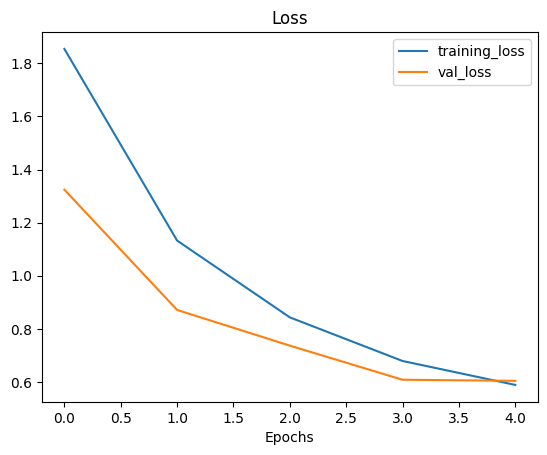

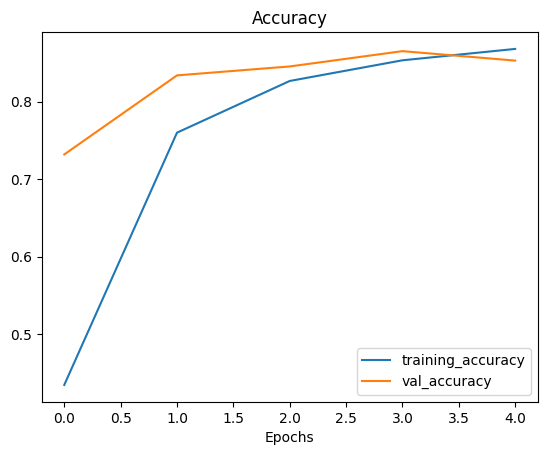

In [68]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model

> 🤔 **Question:** What happens with the `tf.keras.layers.GlobalAveragePooling2D()` layer? I haven't seen it before.

The [`tf.keras.layers.GlobalAveragePooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) layer transforms a 4D tensor into a 2D tensor by averaging the values across the inner-axes.

The previous sentence is a bit of a mouthful, so let's see an example.

In [69]:
# Define input tensor shape (same number of dimensions as the output of efficientnetv2-b0)
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shapes of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global averaged pooled input tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global averaged pooled input tensor: (1, 3)


You can see the `tf.keras.layers.GlobalAveragePooling2D()` layer condensed the input tensor from shape `(1, 4, 4, 3)` to `(1, 3)`. It did so by averaging the `input_tensor` across the middle two axes.

We can replicate this operation using the `tf.reduce_mean()` operation and specifying the appropriate axes.

In [70]:
# This is the same as GlobalAveragePooling2D()
tf.reduce_mean(input_tensor, axis=[1, 2]) # average across the middle axes

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

Doing this not only makes the output of the base model compatible with the input shape requirement of our output layer (`tf.keras.layers.Dense()`), it also condenses the information found by the base model into a lower dimension **feature vector**.

> 🔑 **Note:** One of the reasons feature extraction transfer learning is named how it is is because what often happens is a pretrained model outputs a **feature vector** (a long tensor of numbers, in our case, this is the output of the [`tf.keras.layers.GlobalAveragePooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) layer) which can then be used to extract patterns out of.

> 🛠 **Practice:** Do the same as the above cell but for [`tf.keras.layers.GlobalMaxPool2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool2D).

In [71]:
# Pass the random tensor through a global max pooling 2D layer
global_max_pooled_tensor = tf.keras.layers.GlobalMaxPool2D()(input_tensor)
print(f"2D global max pooled random tensor:\n {global_max_pooled_tensor}\n")

# Check the shapes of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global maxed pooled input tensor: {global_max_pooled_tensor.shape}")

# Reproduce the same result using reduce_max
reproduce_max = tf.reduce_max(input_tensor, axis=[1, 2]) # take the max across the middle axes
print(f"Reproduced max as global max pooled tensor:\n {reproduce_max}\n") # will be the same as GlobalMaxPool2D()

2D global max pooled random tensor:
 [[0.9058464 1.1603122 1.6994323]]

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global maxed pooled input tensor: (1, 3)
Reproduced max as global max pooled tensor:
 [[0.9058464 1.1603122 1.6994323]]



## Running a series of transfer learning experiments

We've seen the incredible results of transfer learning on 10% of the training data, what about 1% of the training data?

What kind of results do you think we can get using 100x less data than the original CNN models we built ourselves?

Why don't we answer that question while running the following modelling experiments:
1. **Model 1**: Use feature extraction transfer learning on 1% of the training data with data augmentation.
2. **Model 2**: Use feature extraction transfer learning on 10% of the training data with data augmentation and save the results to a checkpoint.
3. **Model 3**: Fine-tune the **Model 2** checkpoint on 10% of the training data with data augmentation.
4. **Model 4**: Fine-tune the **Model 2** checkpoint on 100% of the training data with data augmentation.

While all of the experiments will be run on different versions of the training data, they will all be evaluated on the **same test dataset**, this ensures the results of each experiment are as comparable as possible.

All experiments will be done using the `EfficientNetV2B0` model within the `tf.keras.applications.efficientnet_v2` module.

To make sure we're keeping track of our experiments, we'll use our `create_tensorboard_callback()` function to log all of the model training logs.

We'll construct each model using the Keras Functional API and instead of implementing data augmentation in the `ImageDataGenerator` class as we have previously, we're going to build it right into the model using the [`tf.keras.layers`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/) module.

Let's begin by downloading the data for experiment 1, using feature extraction transfer learning on 1% of the training data with data augmentation.

In [72]:
# Download and unzip data (skip, load the data locally)
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
# unzip_data("10_food_classes_1_percent.zip")

# Create training and test dirs
image_data_dir = "data/image_data/"
train_dir_1_percent = image_data_dir + "10_food_classes_1_percent/train/"
test_dir = image_data_dir + "10_food_classes_1_percent/test/"

In [73]:
# Walk through 1 percent data directory and list number of files
walk_through_dir(train_dir_1_percent)

There are 10 directories and 0 images in 'data/image_data/10_food_classes_1_percent/train/'.
There are 0 directories and 7 images in 'data/image_data/10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in 'data/image_data/10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in 'data/image_data/10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in 'data/image_data/10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in 'data/image_data/10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in 'data/image_data/10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in 'data/image_data/10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in 'data/image_data/10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in 'data/image_data/10_food_classes_1_percent/train/stea

Alright, looks like we've only got seven images of each class, this should be a bit of a challenge for our model.

> 🔑 **Note:** As with the 10% of data subset, the 1% of images were chosen at random from the original full training dataset. The test images are the same as the ones which have previously been used. If you want to see how this data was preprocessed, check out the [Food Vision Image Preprocessing notebook](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb).

Time to load our images in as `tf.data.Dataset` objects, to do so, we'll use the [`image_dataset_from_directory()`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) method.

In [74]:
import tensorflow as tf

IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_1_percent,
    label_mode="categorical",
    batch_size=32,  # default
    image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir, label_mode="categorical", image_size=IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Adding data augmentation right into the model

Previously we've used the different parameters of the `ImageDataGenerator` class to augment our training images, this time we're going to build data augmentation right into the model.

How?

Using the [`tf.keras.layers`](https://www.tensorflow.org/api_docs/python/tf/keras/layers) module and creating a dedicated data augmentation layer.

This a relatively new feature added to TensorFlow 2.10+ but it's very powerful. Adding a data augmentation layer to the model has the following benefits:
* Preprocessing of the images (augmenting them) happens on the GPU rather than on the CPU (much faster).
  * Images are best preprocessed on the GPU where as text and structured data are more suited to be preprocessed on the CPU.
* Image data augmentation only happens during training so we can still export our whole model and use it elsewhere. And if someone else wanted to train the same model as us, including the same kind of data augmentation, they could.

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/05-data-augmentation-inside-a-model.png)
*Example of using data augmentation as the first layer within a model (EfficientNetB0).*

> 📚 **Resource:** For more information on different methods of data augmentation, check out the the [TensorFlow data augmentation guide](https://www.tensorflow.org/tutorials/images/data_augmentation).

To use data augmentation right within our model we'll create a Keras Sequential model consisting of only data preprocessing layers, we can then use this Sequential model within another Functional model.

If that sounds confusing, it'll make sense once we create it in code.

The data augmentation transformations we're going to use are:
* [`tf.keras.layers.RandomFlip`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomFlip) - flips image on horizontal or vertical axis.
* [`tf.keras.layersRandomRotation`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomRotation) - randomly rotates image by a specified amount.
* [`tf.keras.layers.RandomZoom`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomZoom) - randomly zooms into an image by specified amount.
* [`tf.keras.layers.RandomHeight`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomHeight) - randomly shifts image height by a specified amount.
* [`tf.keras.layers.RandomWidth`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomWidth) - randomly shifts image width by a specified amount.
* [`tf.keras.layers.Rescaling`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling) - normalizes the image pixel values to be between 0 and 1, this is worth mentioning because it is required for some image models but since we're using [`tf.keras.applications.efficientnet_v2.EfficientNetV2B0`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet_v2/EfficientNetV2B0), it's not required (the model pretrained model implements rescaling itself).

There are more option but these will do for now.

In [75]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# from tensorflow.keras.layers.experimental import preprocessing

# NEW: Newer versions of TensorFlow (2.10+) can use the tensorflow.keras.layers API directly for data augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
        layers.RandomHeight(0.2),
        layers.RandomWidth(0.2),
        # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetV2B0
    ],
    name="data_augmentation")

# # UPDATE: Previous versions of TensorFlow (e.g. 2.4 and below used the tensorflow.keras.layers.experimental.processing API)
# # Create a data augmentation stage with horizontal flipping, rotations, zooms
# data_augmentation = keras.Sequential([
#   preprocessing.RandomFlip("horizontal"),
#   preprocessing.RandomRotation(0.2),
#   preprocessing.RandomZoom(0.2),
#   preprocessing.RandomHeight(0.2),
#   preprocessing.RandomWidth(0.2),
#   # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetV2B0
# ], name ="data_augmentation")

And that's it! Our data augmentation Sequential model is ready to go.

As you'll see shortly, we'll be able to slot this "model" as a layer into our transfer learning model later on.

But before we do that, let's test it out by passing random images through it.

(-0.5, 442.5, 600.5, -0.5)

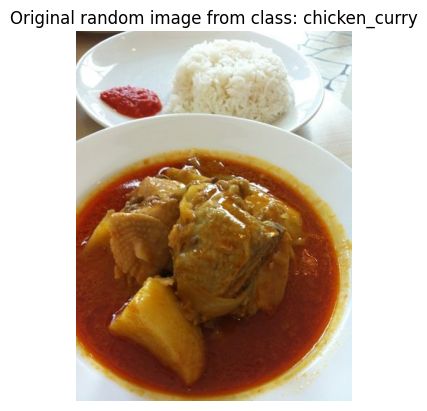

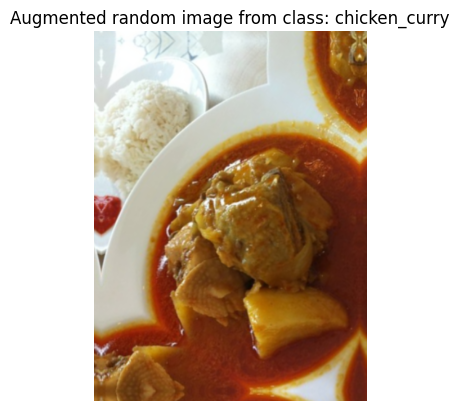

In [76]:
# View a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)  # choose a random class
target_dir = train_dir_1_percent + target_class  # create the target directory
random_image = random.choice(os.listdir(target_dir))  # choose a random image from target directory
random_image_path = target_dir + "/" + random_image  # create the choosen random image path
img = mpimg.imread(random_image_path)  # read in the chosen target image
plt.imshow(img)  # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False)
# turn off the axes

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0))  # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img) / 255.)  # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False)


Run the cell above a few times and you can see the different random augmentations on different classes of images. Because we're going to add the data augmentation model as a layer in our upcoming transfer learning model, it'll apply these kind of random augmentations to each of the training images which passes through it.

Doing this will make our training dataset a little more varied. You can think of it as if you were taking a photo of food in real-life, not all of the images are going to be perfect, some of them are going to be orientated in strange ways. These are the kind of images we want our model to be able to handle.

Speaking of model, let's build one with the Functional API. We'll run through all of the same steps as before except for one difference, we'll add our data augmentation Sequential model as a layer immediately after the input layer.

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [81]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Resize the input images to the expected shape
resize_layer = tf.keras.layers.Resizing(512, 382, name="resize_layer")
x = resize_layer(inputs)

# Add in data augmentation Sequential model as a layer
x = data_augmentation(x)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model with inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(
    train_data_1_percent.repeat(),
    epochs=5,
    steps_per_epoch=len(train_data_1_percent),
    validation_data=test_data,
    validation_steps=int(0.25 * len(test_data)),  # validate for less steps
    # Track model training logs
    callbacks=[create_tensorboard_callback("1_percent_data_aug")])

Saving TensorBoard log files to: logs/transfer_learning_part_2/1_percent_data_aug
Epoch 1/5


W0000 00:00:1737762766.996026    6822 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762767.095922    6822 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762767.098199    6822 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762767.101256    6822 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762767.104236    6822 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762767.107585    6822 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762767.113260    6822 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762767.120296    6822 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762767.125538    6822 gp

1/3 ━━━━━━━━━━━━━━━━━━━━ 13s 7s/step - accuracy: 0.0000e+00 - loss: 2.3879

W0000 00:00:1737762768.837151    6816 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762768.839441    6816 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762768.841464    6816 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762768.844263    6816 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762768.846963    6816 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762768.849510    6816 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762768.853974    6816 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762768.859324    6816 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762768.863052    6816 gp

2/3 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 0.0156 - loss: 2.3867     

W0000 00:00:1737762770.555404    6812 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762770.556644    6812 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762770.557676    6812 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762770.558813    6812 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762770.559879    6812 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762770.561070    6812 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762770.562461    6812 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762770.563968    6812 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762770.565259    6812 gp

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0295 - loss: 2.3796

W0000 00:00:1737762770.966662    6812 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762770.969082    6812 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762770.988508    6812 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762772.237339    6816 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762772.239637    6816 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762772.241822    6816 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762772.244859    6816 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762772.247789    6816 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762772.250289    6816 gp

3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - accuracy: 0.0364 - loss: 2.3760 - val_accuracy: 0.1365 - val_loss: 2.2170
Epoch 2/5


W0000 00:00:1737762776.308051    6817 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762776.310112    6817 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762776.312183    6817 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762776.314793    6817 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762776.317308    6817 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762776.319716    6817 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762776.323850    6817 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762776.328756    6817 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762776.332116    6817 gp

1/3 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.1562 - loss: 2.1563

W0000 00:00:1737762777.911767    6819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762777.913543    6819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762777.915114    6819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762777.917155    6819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762777.919169    6819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762777.921086    6819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762777.924231    6819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762777.928007    6819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762777.930706    6819 gp

2/3 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.1641 - loss: 2.1733

W0000 00:00:1737762779.094341    6822 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762779.095598    6822 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762779.096553    6822 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762779.097637    6822 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762779.098703    6822 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762779.099857    6822 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762779.101100    6822 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762779.102472    6822 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762779.103723    6822 gp

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 805ms/step - accuracy: 0.1618 - loss: 2.1833

W0000 00:00:1737762779.296018    6822 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762779.297090    6822 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762779.298233    6822 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762779.299301    6822 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762779.300552    6822 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762779.302027    6822 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762779.303178    6822 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762779.304476    6822 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762779.305776    6822 gp

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.1606 - loss: 2.1883 - val_accuracy: 0.1924 - val_loss: 2.1421
Epoch 3/5


W0000 00:00:1737762782.055457    6802 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762782.057611    6802 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762782.059513    6802 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762782.062081    6802 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762782.064740    6802 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762782.067149    6802 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762782.071416    6802 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762782.076448    6802 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762782.079959    6802 gp

1/3 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.4688 - loss: 2.0088

W0000 00:00:1737762783.759732    6802 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762783.761571    6802 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762783.763263    6802 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762783.765521    6802 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762783.767761    6802 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762783.769892    6802 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762783.773647    6802 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762783.778070    6802 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762783.781203    6802 gp

2/3 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4766 - loss: 2.0068

W0000 00:00:1737762784.911137    6802 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762784.913150    6802 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762784.915529    6802 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762784.918272    6802 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762784.921208    6802 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762784.924221    6802 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762784.926739    6802 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762784.930994    6802 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762784.935330    6802 gp

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 957ms/step - accuracy: 0.4796 - loss: 1.9997

W0000 00:00:1737762785.528847    6801 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762785.560877    6801 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762785.562113    6801 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762785.563278    6801 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762785.564465    6801 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762785.565540    6801 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762785.566699    6801 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762785.567906    6801 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762785.569059    6801 gp

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.4811 - loss: 1.9962 - val_accuracy: 0.2780 - val_loss: 2.0246
Epoch 4/5


W0000 00:00:1737762788.194563    6803 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762788.196436    6803 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762788.198124    6803 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762788.200405    6803 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762788.202636    6803 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762788.204707    6803 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762788.208275    6803 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762788.212521    6803 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762788.215505    6803 gp

1/3 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.4062 - loss: 1.8961

W0000 00:00:1737762789.380086    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762789.381868    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762789.383451    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762789.385609    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762789.387744    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762789.389829    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762789.393152    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762789.397090    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762789.399884    6813 gp

2/3 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4219 - loss: 1.8884

W0000 00:00:1737762790.451361    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762790.454227    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762790.456972    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762790.460591    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762790.464342    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762790.468758    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762790.473718    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762790.480541    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762790.651075    6807 gp

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 905ms/step - accuracy: 0.4384 - loss: 1.8771

W0000 00:00:1737762791.076581    6807 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762791.077865    6807 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762791.079123    6807 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762791.080300    6807 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762791.081428    6807 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762791.082543    6807 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762791.083703    6807 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762791.084829    6807 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762791.085887    6807 gp

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.4467 - loss: 1.8715 - val_accuracy: 0.3273 - val_loss: 1.9791
Epoch 5/5


W0000 00:00:1737762793.707426    6817 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762793.709263    6817 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762793.710960    6817 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762793.713246    6817 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762793.715539    6817 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762793.717689    6817 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762793.721376    6817 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762793.725913    6817 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762793.728971    6817 gp

1/3 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.5938 - loss: 1.7301

W0000 00:00:1737762794.878514    6817 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762794.881348    6817 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762794.883680    6817 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762794.885754    6817 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762794.887778    6817 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762794.890183    6817 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762794.892989    6817 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762794.895937    6817 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762794.899042    6817 gp

2/3 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5391 - loss: 1.7570

W0000 00:00:1737762796.575210    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762796.576441    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762796.577454    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762796.578791    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762796.579994    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762796.581529    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762796.582885    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762796.584329    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762796.585630    6811 gp

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 955ms/step - accuracy: 0.5356 - loss: 1.7544

W0000 00:00:1737762796.777041    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762796.778358    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762796.779571    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762796.780721    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762796.781936    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762796.783229    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762796.784369    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762796.785694    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762796.787117    6811 gp

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5338 - loss: 1.7531 - val_accuracy: 0.2206 - val_loss: 2.0334


Wow!

How cool is that? Using only 7 training images per class, using transfer learning our model was able to get ~45%+ accuracy on the validation set.

This result is pretty amazing since the [original Food-101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf) achieved 50.67% accuracy with all the data, namely, 750 training images per class (**note:** this metric was across 101 classes, not 10, we'll get to 101 classes soon).

If we check out a summary of our model, we should see the data augmentation layer just after the input layer.

In [82]:
# Check out model summary
model_1.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resize_layer (Resizing)         │ (None, 512, 382, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, None, None,     │     5,919,312 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,957,744 (22.73 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

 Optimizer params: 25,622 (100.09 KB)

There it is. We've now got data augmentation built right into the our model. This means if we saved it and reloaded it somewhere else, the data augmentation layers would come with it.

The important thing to remember is **data augmentation only runs during training**. So if we were to evaluate or use our model for inference (predicting the class of an image) the data augmentation layers will be automatically turned off.

To see this in action, let's evaluate our model on the test data.

In [83]:
# Evaluate on the test data
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.3672 - loss: 1.9166


[1.9177924394607544, 0.36160001158714294]

The results here may be slightly better/worse than the log outputs of our model during training because during training we only evaluate our model on 25% of the test data using the line `validation_steps=int(0.25 * len(test_data))`. Doing this speeds up our epochs but still gives us enough of an idea of how our model is going.

Let's stay consistent and check out our model's loss curves.

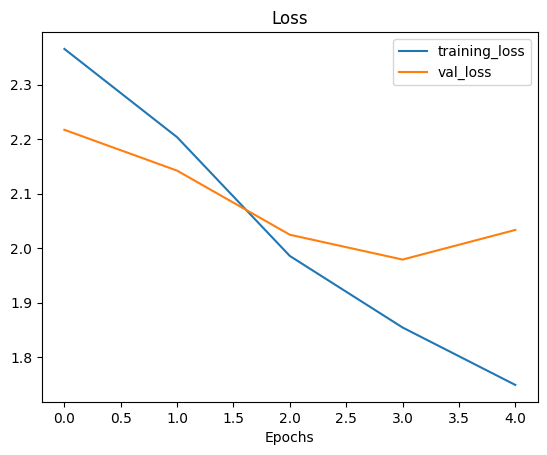

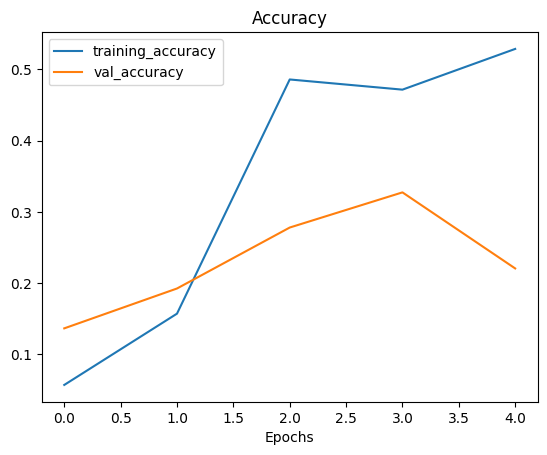

In [84]:
# How does the model go with a data augmentation layer with 1% of data
plot_loss_curves(history_1_percent)

It looks like the metrics on both datasets would improve if we kept training for more epochs. But we'll leave that for now, we've got more experiments to do!

## Model 2: Feature extraction transfer learning with 10% of data and data augmentation

Alright, we've tested 1% of the training data with data augmentation, how about we try 10% of the data with data augmentation?

But wait...

> 🤔 **Question:** How do you know what experiments to run?

Great question.

The truth here is you often won't. Machine learning is still a very experimental practice. It's only after trying a fair few things that you'll start to develop an intuition of what to try.

My advice is to follow your curiosity as tenaciously as possible. If you feel like you want to try something, write the code for it and run it. See how it goes. The worst thing that'll happen is you'll figure out what doesn't work, the most valuable kind of knowledge.

From a practical standpoint, as we've talked about before, you'll want to reduce the amount of time between your initial experiments as much as possible. In other words, run a plethora of smaller experiments, using less data and less training iterations before you find something promising and then scale it up.

In the theme of scale, let's scale our 1% training data augmentation experiment up to 10% training data augmentation. That sentence doesn't really make sense but you get what I mean.

We're going to run through the exact same steps as the previous model, the only difference being using 10% of the training data instead of 1%.

In [85]:
food_classes_dir = "data/image_data/10_food_classes_10_percent"
train_dir_10_percent = food_classes_dir + "/train/"
test_dir = food_classes_dir + "/test/"

In [86]:
# Setup data inputs
import tensorflow as tf

IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
# Note: the test data is the same as the previous experiment, we could
# skip creating this, but we'll leave this here to practice.
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir, label_mode="categorical", image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Awesome!

We've got 10x more images to work with, 75 per class instead of 7 per class.

Let's build a model with data augmentation built in. We could reuse the data augmentation Sequential model we created before but we'll recreate it to practice.

In [87]:
# Create a functional model with data augmentation
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers.experimental import preprocessing # OLD

# NEW: Newer versions of TensorFlow (2.10+) can use the tensorflow.keras.layers API directly for data augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
        layers.RandomHeight(0.2),
        layers.RandomWidth(0.2),
        # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet
    ],
    name="data_augmentation")

## OLD
# # Build data augmentation layer
# data_augmentation = Sequential([
#   preprocessing.RandomFlip('horizontal'),
#   preprocessing.RandomHeight(0.2),
#   preprocessing.RandomWidth(0.2),
#   preprocessing.RandomZoom(0.2),
#   preprocessing.RandomRotation(0.2),
#   # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet
# ], name="data_augmentation")

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model
# base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer")  # create input layer
x = data_augmentation(inputs)  # augment our training images
x = base_model(
    x, training=False
)  # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # use Adam optimizer with base learning rate
    metrics=["accuracy"])

In [88]:
def create_base_model(input_shape: tuple[int, int, int] = (224, 224, 3),
                      output_shape: int = 10,
                      learning_rate: float = 0.001,
                      training: bool = False) -> tf.keras.Model:
    """
    Create a model based on EfficientNetV2B0 with built-in data augmentation.

    Parameters:
    - input_shape (tuple): Expected shape of input images. Default is (224, 224, 3).
    - output_shape (int): Number of classes for the output layer. Default is 10.
    - learning_rate (float): Learning rate for the Adam optimizer. Default is 0.001.
    - training (bool): Whether the base model is trainable. Default is False.

    Returns:
    - tf.keras.Model: The compiled model with specified input and output settings.
    """

    # Create base model
    base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
    base_model.trainable = training

    # Setup model input and outputs with data augmentation built-in
    inputs = layers.Input(shape=input_shape, name="input_layer")
    x = data_augmentation(inputs)
    x = base_model(x, training=False)  # pass augmented images to base model but keep it in inference mode
    x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
    outputs = layers.Dense(units=output_shape, activation="softmax", name="output_layer")(x)
    model = tf.keras.Model(inputs, outputs)

    # Compile model
    model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=["accuracy"])

    return model


# Create an instance of model_2 with our new function
model_2 = create_base_model()

In [89]:
model_2.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, None, None,     │     5,919,312 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,932,122 (22.63 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

### Creating a ModelCheckpoint callback

Our model is compiled and ready to be fit, so why haven't we fit it yet?

Well, for this experiment we're going to introduce a new callback, the `ModelCheckpoint` callback.

The [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback gives you the ability to save your model, as a whole in the [`SavedModel`](https://www.tensorflow.org/tutorials/keras/save_and_load#save_the_entire_model) format or the [weights (patterns) only](https://www.tensorflow.org/tutorials/keras/save_and_load#manually_save_weights) to a specified directory as it trains.

This is helpful if you think your model is going to be training for a long time and you want to make backups of it as it trains. It also means if you think your model could benefit from being trained for longer, you can reload it from a specific checkpoint and continue training from there.

For example, say you fit a feature extraction transfer learning model for 5 epochs and you check the training curves and see it was still improving and you want to see if fine-tuning for another 5 epochs could help, you can load the checkpoint, unfreeze some (or all) of the base model layers and then continue training.

In fact, that's exactly what we're going to do.

But first, let's create a `ModelCheckpoint` callback. To do so, we have to specifcy a directory we'd like to save to.

In [90]:
# Setup checkpoint path
checkpoint_path = "logs/transfer_learning_part_2/ten_percent_model_checkpoints_weights/checkpoint.weights.h5"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,  # set to False to save the entire model
    save_best_only=True,  # save only the best model weights instead of a model every epoch
    save_freq="epoch",  # save every epoch
    verbose=1)

> 🤔 **Question:** What's the difference between saving the entire model (SavedModel format) and saving the weights only?

The [`SavedModel`](https://www.tensorflow.org/tutorials/keras/save_and_load#save_the_entire_model) format saves a model's architecture, weights and training configuration all in one folder. It makes it very easy to reload your model exactly how it is elsewhere. However, if you do not want to share all of these details with others, you may want to save and share the weights only (these will just be large tensors of non-human interpretable numbers). If disk space is an issue, saving the weights only is faster and takes up less space than saving the whole model.

Time to fit the model.

Because we're going to be fine-tuning it later, we'll create a variable `initial_epochs` and set it to 5 to use later.

We'll also add in our `checkpoint_callback` in our list of `callbacks`.

In [91]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(
    train_data_10_percent,
    epochs=initial_epochs,
    validation_data=test_data,
    validation_steps=int(0.25 * len(test_data)),  # do less steps per validation (quicker)
    callbacks=[create_tensorboard_callback("10_percent_data_aug"), checkpoint_callback])

Saving TensorBoard log files to: logs/transfer_learning_part_2/10_percent_data_aug
Epoch 1/5


 3/24 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.1146 - loss: 2.3558 

W0000 00:00:1737762846.589638    6806 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762846.591078    6806 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762846.592296    6806 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762846.593670    6806 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762846.594999    6806 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762846.596460    6806 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762846.598303    6806 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762846.600469    6806 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762846.602448    6806 gp

 4/24 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.1309 - loss: 2.3319

W0000 00:00:1737762846.843696    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762846.845074    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762846.846232    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762846.847665    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762846.849038    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762846.850331    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762846.852130    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762846.854203    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762846.855896    6811 gp

 6/24 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.1423 - loss: 2.3140

W0000 00:00:1737762847.063645    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762847.065180    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762847.066508    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762847.067832    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762847.069205    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762847.070648    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762847.072101    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762847.073459    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762847.074845    6811 gp

 7/24 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 0.1475 - loss: 2.3063

W0000 00:00:1737762847.300485    6801 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762847.301830    6801 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762847.303042    6801 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762847.304533    6801 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762847.305957    6801 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762847.307359    6801 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762847.309362    6801 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762847.311626    6801 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762847.313369    6801 gp

 8/24 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - accuracy: 0.1525 - loss: 2.2967

W0000 00:00:1737762847.745211    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762847.746500    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762847.747490    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762847.748607    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762847.749709    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762847.750917    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762847.752373    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762847.753964    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762847.755334    6818 gp

10/24 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - accuracy: 0.1634 - loss: 2.2767

W0000 00:00:1737762847.946460    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762847.947901    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762847.950510    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762848.025196    6805 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762848.026482    6805 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762848.027512    6805 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762848.028659    6805 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762848.029804    6805 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762848.030993    6805 gp

13/24 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.1804 - loss: 2.2504

W0000 00:00:1737762848.147747    6808 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762848.149703    6808 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762848.152173    6808 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762848.154612    6808 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762848.157086    6808 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762848.159185    6808 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762848.161641    6808 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762848.163847    6808 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762848.165968    6808 gp

14/24 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.1860 - loss: 2.2418

W0000 00:00:1737762848.354207    6821 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762848.355398    6821 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762848.356443    6821 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762848.357574    6821 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762848.358647    6821 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762848.359756    6821 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762848.361233    6821 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762848.362815    6821 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762848.364189    6821 gp

15/24 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.1913 - loss: 2.2338

W0000 00:00:1737762848.559355    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762848.563262    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762848.565292    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762848.567338    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762848.572673    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762848.577742    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762848.603916    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762848.605191    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762848.606335    6811 gp

17/24 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - accuracy: 0.2004 - loss: 2.2184

W0000 00:00:1737762849.242279    6819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762849.243520    6819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762849.244643    6819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762849.245959    6819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762849.247220    6819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762849.248503    6819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762849.250277    6819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762849.252271    6819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762849.253886    6819 gp

19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.2101 - loss: 2.2033

W0000 00:00:1737762849.445586    6814 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762849.447887    6814 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762849.450400    6814 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762849.453646    6814 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762849.457141    6814 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762849.521583    6817 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762849.522835    6817 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762849.523980    6817 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762849.525297    6817 gp

20/24 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.2153 - loss: 2.1956

W0000 00:00:1737762849.649463    6817 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762849.654896    6817 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762849.659640    6817 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762849.663863    6817 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762849.670807    6817 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762849.674004    6817 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762849.680487    6817 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762849.686385    6817 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762849.689314    6817 gp

21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.2202 - loss: 2.1884

W0000 00:00:1737762850.082988    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762850.084498    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762850.085830    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762850.087242    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762850.088598    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762850.090020    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762850.091434    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762850.092897    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762850.094141    6813 gp

23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.2294 - loss: 2.1749

W0000 00:00:1737762850.573380    6805 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762850.574504    6805 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762850.575448    6805 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762850.576346    6805 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762850.577200    6805 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762850.578136    6805 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762850.579216    6805 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762850.580346    6805 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762850.581496    6805 gp

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.2338 - loss: 2.1685

W0000 00:00:1737762850.780343    6805 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762850.781332    6805 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762850.782100    6805 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762850.782829    6805 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762850.783553    6805 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762850.784284    6805 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762850.785039    6805 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762850.785771    6805 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762850.786593    6805 gp


Epoch 1: val_loss improved from inf to 1.50976, saving model to logs/transfer_learning_part_2/ten_percent_model_checkpoints_weights/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 286ms/step - accuracy: 0.2378 - loss: 2.1627 - val_accuracy: 0.6480 - val_loss: 1.5098
Epoch 2/5


W0000 00:00:1737762853.194222    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762853.195465    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762853.196584    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762853.197865    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762853.199066    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762853.200310    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762853.201929    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762853.203714    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762853.205619    6811 gp

 3/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.5938 - loss: 1.6605  

W0000 00:00:1737762853.597995    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762853.599156    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762853.600262    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762853.601404    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762853.602556    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762853.604028    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762853.605449    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762853.606518    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762853.607556    6811 gp

 4/24 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 0.5977 - loss: 1.6447

W0000 00:00:1737762854.033214    6810 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762854.034739    6810 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762854.036080    6810 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762854.037538    6810 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762854.038849    6810 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762854.040340    6810 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762854.041830    6810 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762854.043225    6810 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762854.044616    6810 gp

 7/24 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - accuracy: 0.6017 - loss: 1.5996

W0000 00:00:1737762854.501449    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762854.502690    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762854.503737    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762854.504871    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762854.505988    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762854.507109    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762854.508511    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762854.510197    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762854.511647    6813 gp

 9/24 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - accuracy: 0.6048 - loss: 1.5815

W0000 00:00:1737762854.926909    6823 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762854.928260    6823 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762854.929523    6823 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762854.930902    6823 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762854.932423    6823 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762854.933678    6823 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762854.935206    6823 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762854.936428    6823 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762854.937808    6823 gp

10/24 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step - accuracy: 0.6047 - loss: 1.5746

W0000 00:00:1737762855.332615    6806 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762855.334109    6806 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762855.335624    6806 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762855.337230    6806 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762855.338798    6806 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762855.340636    6806 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762855.342537    6806 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762855.343870    6806 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762855.345443    6806 gp

11/24 ━━━━━━━━━━━━━━━━━━━━ 2s 201ms/step - accuracy: 0.6052 - loss: 1.5684

W0000 00:00:1737762855.534202    6823 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762855.537827    6823 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762855.541232    6823 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762855.544295    6823 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762855.548870    6823 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762855.550650    6823 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762855.555101    6823 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762855.559270    6823 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762855.561295    6823 gp

15/24 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.6098 - loss: 1.5465

W0000 00:00:1737762856.047900    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762856.049009    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762856.050007    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762856.051189    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762856.052292    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762856.053428    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762856.054814    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762856.056395    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762856.057744    6811 gp

17/24 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - accuracy: 0.6124 - loss: 1.5378

W0000 00:00:1737762856.311792    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762856.313080    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762856.314223    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762856.315435    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762856.316649    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762856.317873    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762856.319457    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762856.321332    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762856.322851    6818 gp

19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.6143 - loss: 1.5296

W0000 00:00:1737762856.826479    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762856.827659    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762856.828693    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762856.829858    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762856.830982    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762856.832097    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762856.833599    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762856.835221    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762856.836610    6813 gp

21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.6160 - loss: 1.5223

W0000 00:00:1737762857.028762    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762857.030362    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762857.032161    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762857.033408    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762857.034874    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762857.037471    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762857.150751    6823 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762857.151980    6823 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762857.153035    6823 gp

23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.6179 - loss: 1.5149

W0000 00:00:1737762857.230658    6823 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762857.233513    6823 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762857.236511    6823 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762857.239303    6823 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762857.241690    6823 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762857.244116    6823 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762857.245888    6823 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762857.248817    6823 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762857.251605    6823 gp


Epoch 2: val_loss improved from 1.50976 to 1.09902, saving model to logs/transfer_learning_part_2/ten_percent_model_checkpoints_weights/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 216ms/step - accuracy: 0.6192 - loss: 1.5085 - val_accuracy: 0.7533 - val_loss: 1.0990
Epoch 3/5
 1/24 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - accuracy: 0.7188 - loss: 1.2220

W0000 00:00:1737762858.690345    6817 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762858.691857    6817 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762858.693125    6817 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762858.694694    6817 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762858.696355    6817 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762858.697813    6817 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762858.699964    6817 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762858.702413    6817 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762858.704158    6817 gp

 2/24 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.7109 - loss: 1.2072

W0000 00:00:1737762858.936824    6810 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762858.938172    6810 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762858.939283    6810 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762858.940582    6810 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762858.941844    6810 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762858.943034    6810 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762858.944676    6810 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762858.946485    6810 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762858.947971    6810 gp

 3/24 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - accuracy: 0.7274 - loss: 1.1791

W0000 00:00:1737762859.137991    6810 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762859.139388    6810 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762859.140702    6810 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762859.141899    6810 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762859.143119    6810 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762859.144324    6810 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762859.145649    6810 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762859.147012    6810 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762859.148222    6810 gp

 4/24 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - accuracy: 0.7409 - loss: 1.1643

W0000 00:00:1737762859.374279    6806 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762859.375585    6806 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762859.376692    6806 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762859.377976    6806 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762859.379206    6806 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762859.380552    6806 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762859.382184    6806 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762859.384033    6806 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762859.385558    6806 gp

 5/24 ━━━━━━━━━━━━━━━━━━━━ 4s 214ms/step - accuracy: 0.7490 - loss: 1.1541

W0000 00:00:1737762859.576859    6806 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762859.578198    6806 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762859.579474    6806 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762859.580774    6806 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762859.582001    6806 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762859.583439    6806 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762859.584858    6806 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762859.586109    6806 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762859.587682    6806 gp

 6/24 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/step - accuracy: 0.7569 - loss: 1.1425

W0000 00:00:1737762859.781504    6803 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762859.783965    6803 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762859.787637    6803 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762859.789230    6803 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762859.792774    6803 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762859.796217    6803 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762859.798108    6803 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762859.799872    6803 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762859.804594    6803 gp

 7/24 ━━━━━━━━━━━━━━━━━━━━ 4s 236ms/step - accuracy: 0.7617 - loss: 1.1377

W0000 00:00:1737762860.250108    6812 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762860.251366    6812 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762860.252426    6812 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762860.253557    6812 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762860.254694    6812 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762860.255824    6812 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762860.257258    6812 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762860.258874    6812 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762860.260250    6812 gp

 8/24 ━━━━━━━━━━━━━━━━━━━━ 3s 242ms/step - accuracy: 0.7641 - loss: 1.1355

W0000 00:00:1737762860.451452    6812 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762860.454035    6812 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762860.523384    6812 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762860.524709    6812 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762860.525907    6812 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762860.527360    6812 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762860.528760    6812 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762860.530164    6812 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762860.532079    6812 gp

10/24 ━━━━━━━━━━━━━━━━━━━━ 3s 241ms/step - accuracy: 0.7659 - loss: 1.1321

W0000 00:00:1737762860.904492    6805 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762860.905601    6805 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762860.906572    6805 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762860.907619    6805 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762860.908678    6805 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762860.909744    6805 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762860.911242    6805 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762860.912742    6805 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762860.914021    6805 gp

12/24 ━━━━━━━━━━━━━━━━━━━━ 3s 256ms/step - accuracy: 0.7651 - loss: 1.1295

W0000 00:00:1737762861.543579    6816 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762861.544718    6816 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762861.545739    6816 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762861.546933    6816 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762861.548103    6816 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762861.549303    6816 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762861.550902    6816 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762861.552658    6816 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762861.554135    6816 gp

13/24 ━━━━━━━━━━━━━━━━━━━━ 2s 256ms/step - accuracy: 0.7647 - loss: 1.1273

W0000 00:00:1737762861.745018    6817 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762861.748407    6817 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762861.751425    6817 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762861.754230    6817 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762861.758288    6817 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762861.760080    6817 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762861.764154    6817 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762861.767904    6817 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762861.769929    6817 gp

14/24 ━━━━━━━━━━━━━━━━━━━━ 2s 243ms/step - accuracy: 0.7635 - loss: 1.1267

W0000 00:00:1737762861.995609    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762861.996743    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762861.997754    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762861.998891    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762862.000007    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762862.001183    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762862.002590    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762862.004168    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762862.005613    6811 gp

15/24 ━━━━━━━━━━━━━━━━━━━━ 2s 245ms/step - accuracy: 0.7615 - loss: 1.1269

W0000 00:00:1737762862.266940    6819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762862.268223    6819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762862.269599    6819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762862.270891    6819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762862.272010    6819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762862.273192    6819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762862.274698    6819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762862.276384    6819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762862.277823    6819 gp

16/24 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step - accuracy: 0.7594 - loss: 1.1275

W0000 00:00:1737762862.469758    6819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762862.541946    6801 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762862.543211    6801 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762862.544268    6801 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762862.545507    6801 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762862.546732    6801 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762862.547976    6801 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762862.549640    6801 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762862.551601    6801 gp

17/24 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step - accuracy: 0.7575 - loss: 1.1280

W0000 00:00:1737762862.671241    6801 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762862.675145    6801 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762862.680920    6801 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762862.683262    6801 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762862.688944    6801 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762862.694205    6801 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762862.696733    6801 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762862.699506    6801 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762862.706650    6801 gp

19/24 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step - accuracy: 0.7544 - loss: 1.1294

W0000 00:00:1737762862.879648    6820 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762862.880973    6820 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762862.882086    6820 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762862.883362    6820 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762862.884640    6820 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762862.885911    6820 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762862.887579    6820 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762862.889500    6820 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762862.891485    6820 gp

20/24 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.7533 - loss: 1.1295

W0000 00:00:1737762863.283764    6821 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762863.285207    6821 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762863.286564    6821 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762863.287956    6821 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762863.289329    6821 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762863.290909    6821 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762863.292470    6821 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762863.293825    6821 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762863.295610    6821 gp

21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.7523 - loss: 1.1295

W0000 00:00:1737762863.529162    6801 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762863.530472    6801 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762863.531613    6801 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762863.532943    6801 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762863.534280    6801 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762863.535638    6801 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762863.537419    6801 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762863.539484    6801 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762863.541213    6801 gp

22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.7510 - loss: 1.1300

W0000 00:00:1737762863.768882    6801 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762863.770511    6801 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762863.771892    6801 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762863.773329    6801 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762863.774663    6801 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762863.776218    6801 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762863.777634    6801 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762863.779087    6801 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762863.780509    6801 gp

23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.7498 - loss: 1.1304

W0000 00:00:1737762864.177957    6823 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762864.179682    6823 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762864.181141    6823 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762864.183148    6823 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762864.184625    6823 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762864.186332    6823 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762864.188061    6823 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762864.189820    6823 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762864.191594    6823 gp

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.7488 - loss: 1.1305

W0000 00:00:1737762864.584089    6803 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762864.585382    6803 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762864.586690    6803 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced



Epoch 3: val_loss improved from 1.09902 to 0.90463, saving model to logs/transfer_learning_part_2/ten_percent_model_checkpoints_weights/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 306ms/step - accuracy: 0.7479 - loss: 1.1306 - val_accuracy: 0.7632 - val_loss: 0.9046
Epoch 4/5


W0000 00:00:1737762865.922280    6812 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762865.924038    6812 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762865.925211    6812 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762865.926586    6812 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762865.928003    6812 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762865.929277    6812 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762865.930989    6812 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762865.932841    6812 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762865.934393    6812 gp

 2/24 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.7188 - loss: 1.0372 

W0000 00:00:1737762866.124632    6812 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762866.126055    6812 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762866.127355    6812 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762866.129003    6812 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762866.130353    6812 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762866.131963    6812 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762866.133449    6812 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762866.134934    6812 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762866.136360    6812 gp

 5/24 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.7663 - loss: 0.9728

W0000 00:00:1737762866.362192    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762866.363520    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762866.364592    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762866.365946    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762866.367111    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762866.368274    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762866.369796    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762866.371540    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762866.372997    6818 gp

 8/24 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.7715 - loss: 0.9637

W0000 00:00:1737762866.781633    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762866.782862    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762866.784287    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762866.785597    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762866.786934    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762866.788175    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762866.789707    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762866.791279    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762866.792554    6818 gp

 9/24 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.7710 - loss: 0.9643

W0000 00:00:1737762867.015416    6809 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762867.016625    6809 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762867.017656    6809 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762867.018800    6809 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762867.019893    6809 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762867.021038    6809 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762867.022445    6809 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762867.024075    6809 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762867.025529    6809 gp

11/24 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.7706 - loss: 0.9643

W0000 00:00:1737762867.272848    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762867.274105    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762867.275190    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762867.276433    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762867.277660    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762867.278892    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762867.280602    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762867.282564    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762867.284166    6818 gp

13/24 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.7711 - loss: 0.9628

W0000 00:00:1737762867.487977    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762867.489298    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762867.490573    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762867.491877    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762867.493201    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762867.494638    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762867.495975    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762867.497344    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762867.498626    6818 gp

15/24 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.7706 - loss: 0.9619

W0000 00:00:1737762867.697143    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762867.698451    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762867.699584    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762867.700965    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762867.702279    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762867.703537    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762867.705334    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762867.707443    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762867.709090    6813 gp

16/24 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.7698 - loss: 0.9622

W0000 00:00:1737762867.929126    6821 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762867.930348    6821 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762867.931663    6821 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762867.933012    6821 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762867.934261    6821 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762867.935469    6821 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762867.937019    6821 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762867.938782    6821 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762867.940256    6821 gp

17/24 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.7692 - loss: 0.9622

W0000 00:00:1737762868.131500    6821 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762868.132811    6821 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762868.134428    6821 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762868.135692    6821 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762868.137172    6821 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762868.138636    6821 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762868.140123    6821 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762868.141658    6821 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762868.143131    6821 gp

18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.7685 - loss: 0.9623

W0000 00:00:1737762868.333134    6820 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762868.336193    6820 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762868.339193    6820 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762868.343417    6820 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762868.347199    6820 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762868.350597    6820 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762868.355639    6820 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762868.357935    6820 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762868.363004    6820 gp

19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.7678 - loss: 0.9626

W0000 00:00:1737762868.535802    6820 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762868.537709    6820 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762868.539518    6820 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762868.541384    6820 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762868.543685    6820 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762868.546002    6820 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762868.548332    6820 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762868.550280    6820 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762868.552634    6820 gp

21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.7663 - loss: 0.9645

W0000 00:00:1737762868.986021    6808 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762868.987155    6808 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762868.988149    6808 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762868.989398    6808 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762868.990605    6808 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762868.991818    6808 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762868.993330    6808 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762868.995051    6808 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762868.996523    6808 gp

22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.7657 - loss: 0.9652

W0000 00:00:1737762869.187200    6808 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762869.188653    6808 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762869.190040    6808 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762869.191618    6808 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762869.193283    6808 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762869.194556    6808 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762869.196065    6808 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762869.198887    6808 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762869.267879    6808 gp

23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.7651 - loss: 0.9659

W0000 00:00:1737762869.391050    6808 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762869.394952    6808 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762869.400571    6808 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762869.403107    6808 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762869.408834    6808 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762869.414007    6808 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762869.416597    6808 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762869.419729    6808 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762869.426893    6808 gp

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.7646 - loss: 0.9665

W0000 00:00:1737762869.812963    6819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762869.813865    6819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762869.814666    6819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762869.815413    6819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762869.816233    6819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762869.817000    6819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762869.817820    6819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762869.818663    6819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762869.819484    6819 gp


Epoch 4: val_loss improved from 0.90463 to 0.74322, saving model to logs/transfer_learning_part_2/ten_percent_model_checkpoints_weights/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 212ms/step - accuracy: 0.7641 - loss: 0.9671 - val_accuracy: 0.8355 - val_loss: 0.7432
Epoch 5/5
 1/24 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 0.8125 - loss: 0.8780

W0000 00:00:1737762871.147869    6819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762871.149255    6819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762871.150512    6819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762871.151922    6819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762871.153328    6819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762871.154628    6819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762871.156402    6819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762871.158359    6819 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762871.160284    6819 gp

 2/24 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.7734 - loss: 0.9295

W0000 00:00:1737762871.397447    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762871.398768    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762871.399994    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762871.401409    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762871.402731    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762871.404044    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762871.405795    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762871.407810    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762871.409450    6813 gp

 3/24 ━━━━━━━━━━━━━━━━━━━━ 4s 228ms/step - accuracy: 0.7830 - loss: 0.9155

W0000 00:00:1737762871.600369    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762871.601873    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762871.603172    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762871.604452    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762871.606234    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762871.607764    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762871.609127    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762871.610445    6813 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762871.611676    6813 gp

 4/24 ━━━━━━━━━━━━━━━━━━━━ 4s 236ms/step - accuracy: 0.7904 - loss: 0.9113

W0000 00:00:1737762871.802512    6820 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762871.804879    6820 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762871.807221    6820 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762871.809791    6820 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762871.812198    6820 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762871.815561    6820 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762871.818510    6820 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762871.821362    6820 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762871.825476    6820 gp

 8/24 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - accuracy: 0.7890 - loss: 0.8981

W0000 00:00:1737762872.309688    6821 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762872.310945    6821 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762872.311970    6821 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762872.313115    6821 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762872.314253    6821 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762872.315401    6821 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762872.316846    6821 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762872.318478    6821 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762872.319852    6821 gp

10/24 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 0.7869 - loss: 0.8953

W0000 00:00:1737762872.571814    6808 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762872.573284    6808 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762872.574347    6808 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762872.575525    6808 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762872.576677    6808 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762872.577851    6808 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762872.579270    6808 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762872.580986    6808 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762872.582426    6808 gp

12/24 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - accuracy: 0.7846 - loss: 0.8939

W0000 00:00:1737762872.975189    6821 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762872.979775    6821 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762873.029690    6821 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762873.040055    6821 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762873.041187    6821 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762873.042297    6821 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762873.043454    6821 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762873.044546    6821 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762873.045730    6821 gp

14/24 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.7821 - loss: 0.8936

W0000 00:00:1737762873.194025    6806 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762873.195433    6806 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762873.196582    6806 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762873.197954    6806 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762873.199252    6806 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762873.200520    6806 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762873.202102    6806 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762873.203916    6806 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762873.205525    6806 gp

15/24 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.7811 - loss: 0.8930

W0000 00:00:1737762873.411351    6820 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762873.412649    6820 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762873.413739    6820 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762873.414893    6820 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762873.416014    6820 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762873.417222    6820 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762873.418684    6820 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762873.420316    6820 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762873.421737    6820 gp

17/24 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.7797 - loss: 0.8911

W0000 00:00:1737762873.615680    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762873.618924    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762873.621938    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762873.626448    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762873.628325    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762873.632891    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762873.637108    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762873.639433    6811 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762873.641801    6811 gp

19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.7789 - loss: 0.8892

W0000 00:00:1737762873.836210    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762873.837631    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762873.838813    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762873.840154    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762873.841446    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762873.842769    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762873.844363    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762873.846198    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762873.847652    6818 gp

20/24 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.7787 - loss: 0.8880

W0000 00:00:1737762874.256241    6809 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762874.257513    6809 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762874.258903    6809 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762874.261685    6809 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762874.329167    6808 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762874.330231    6808 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762874.331246    6808 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762874.332327    6808 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762874.333357    6808 gp

22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.7779 - loss: 0.8872

W0000 00:00:1737762874.476888    6808 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762874.478053    6808 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762874.479054    6808 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762874.480069    6808 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762874.481281    6808 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762874.482467    6808 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762874.483538    6808 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762874.484648    6808 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762874.485747    6808 gp

23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.7773 - loss: 0.8871

W0000 00:00:1737762874.680045    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762874.682161    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762874.684410    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762874.687222    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762874.690050    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762874.692974    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762874.695306    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762874.698175    6818 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762874.700780    6818 gp

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.7769 - loss: 0.8869

W0000 00:00:1737762875.098951    6808 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762875.099982    6808 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762875.101044    6808 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762875.102004    6808 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762875.102959    6808 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762875.104033    6808 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762875.105149    6808 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762875.106364    6808 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1737762875.107581    6808 gp


Epoch 5: val_loss improved from 0.74322 to 0.62342, saving model to logs/transfer_learning_part_2/ten_percent_model_checkpoints_weights/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 204ms/step - accuracy: 0.7766 - loss: 0.8868 - val_accuracy: 0.8824 - val_loss: 0.6234


Would you look at that! Looks like our `ModelCheckpoint` callback worked and our model saved its weights every epoch without too much overhead (saving the whole model takes longer than just the weights).

Let's evaluate our model and check its loss curves.

In [92]:
# Evaluate on the test data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8152 - loss: 0.6841


[0.671881914138794, 0.8263999819755554]

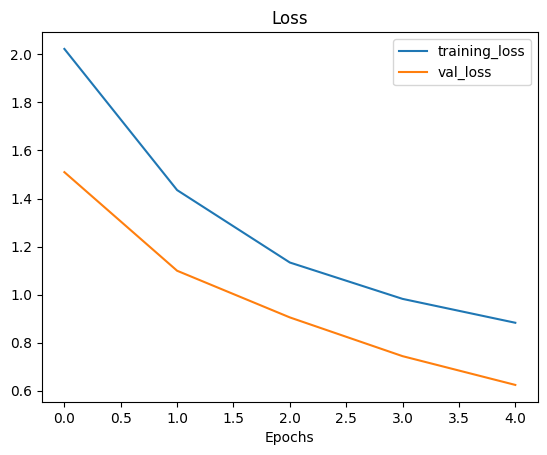

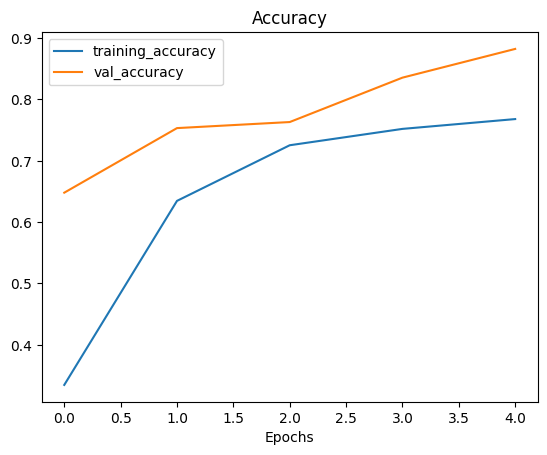

In [93]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)